# PETSc and PyTorch interoperability
## by Hong Zhang

## Integration between simulation and ML
Traditional approaches:
- Save simulation results to files and load them as the training data in a classic ML framework
- Rewrite the simulation codes in a ML framework

These approaches are inefficient and annoying for both computer and human. Can we do in-situ ML for existing simulations?

## Instead
We can combine PETSc and PyTorch into a single python based workflow that allows us to
- Embed **machine learning** into **simulation**
- Embed **simulation** into **machine learning**
- Leverage **automatic differentiation** from PyTorch when using PETSc
- Leverage state-of-the-art **numerical solvers** from PETSc when using PyTorch

## Topics
- How to convert between PETSc vectors/matrices and PyTorch tensors
- How to generate Jacobian or action of Jacobian with PyTorch and use it in PETSc
- How to use PETSc and PyTorch for solving ODEs and training neural ODEs

## Data Structure Conversion Across Libraries
We use the DLPack protocol for efficient conversion between PETSc data structures and tensors.


<div align="center">
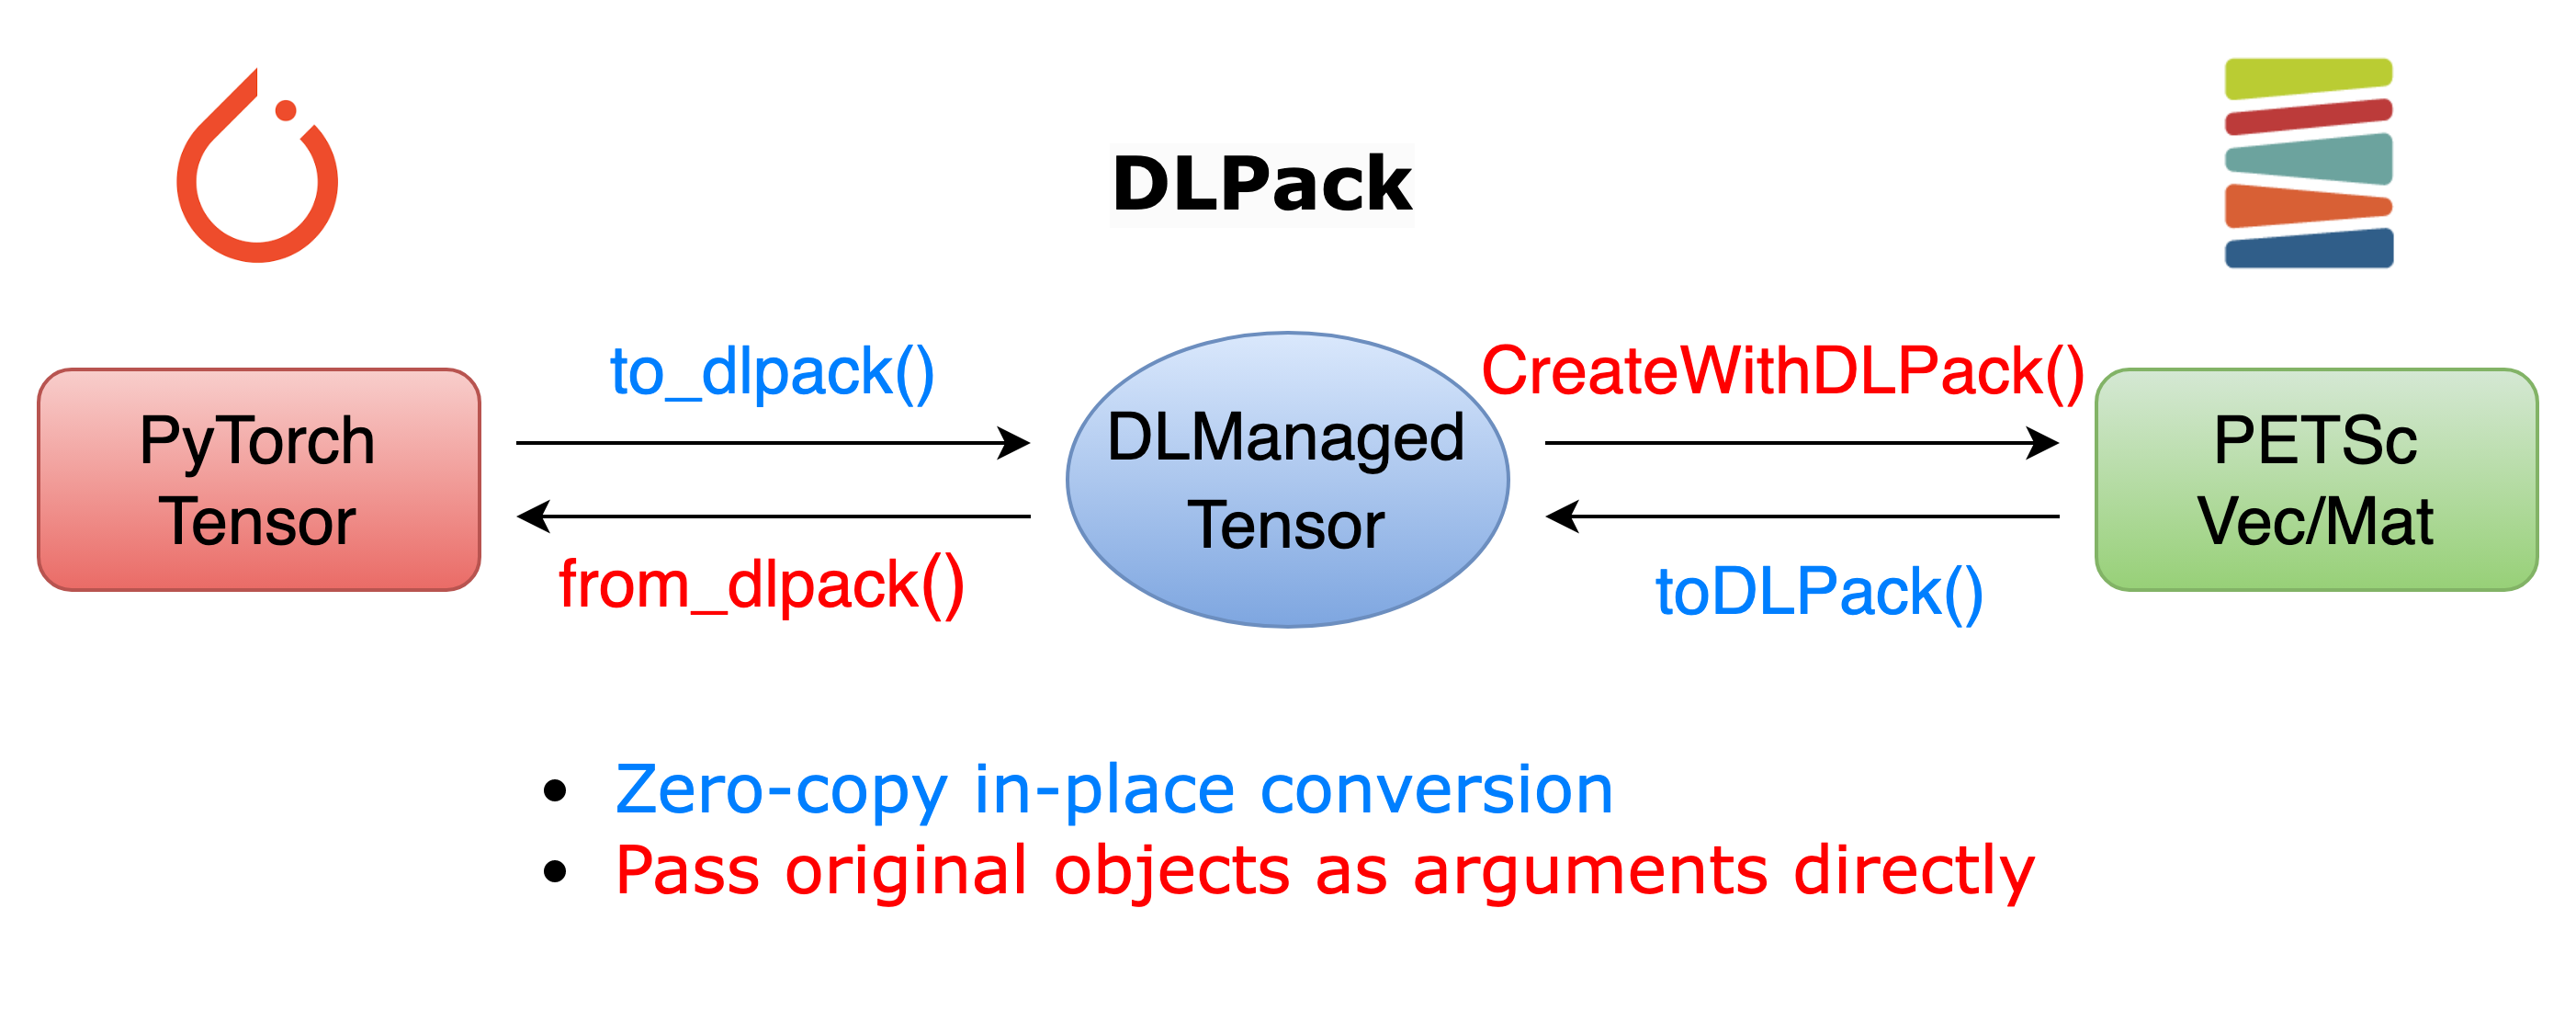
</div>

In [1]:
import sys
import petsc4py
petsc4py.init(sys.argv)
import numpy as np
from petsc4py import PETSc
import torch

## Demo: in-place conversion from PyTorch tensor to PETSc Vec

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
a_tensor = torch.tensor(([1., 2.], [3.,4.]), dtype=torch.float64, device=device)
a_vec = PETSc.Vec().createWithDLPack(a_tensor) #use a_tensor.detach().clone() to avoid interrupting the computation graph 
a_tensor[1][1] = -4.
a_vec.view()
print(a_tensor)

Vec Object: 1 MPI process
  type: seq
1.
2.
3.
-4.
tensor([[ 1.,  2.],
        [ 3., -4.]], dtype=torch.float64)


## Demo: in-place conversion from PETSc Vec to PyTorch tensor

In [3]:
import torch.utils.dlpack as dlpack
# convert PETSc Vec to tensor
b_vec = PETSc.Vec().createWithArray([5.,6.,7.,8.])
b_vec.attachDLPackInfo(a_vec)
b_tensor = dlpack.from_dlpack(b_vec)
print(b_tensor)

tensor([[5., 6.],
        [7., 8.]], dtype=torch.float64)


## Generating the action of Jacobian with PyTorch
- Create the Jacobian matrix with **MatShell**
- Implement your own **MatMult()** operation with autograd from PyTorch
    - Given an input vector X, compute the output vector $$Y= A X$$
    - Compute the **Jacobian-Vector** product by evaluating the RHS function and then calling *autograd.grad()*
- The Jacobian can be passed to PETSc for solving implicit systems

<div style="font-size:20px">

```python
class RHSJacShell:
    def __init__(self, ode):
        self.ode_ = ode
        
    def mult(self, A, X, Y):
        X.attachDLPackInfo(self.ode_.cached_U)
        x_tensor = dlpack.from_dlpack(X.toDLPack(mode="r"))
        Y.attachDLPackInfo(self.ode_.cached_U)
        y = dlpack.from_dlpack(Y)
        with torch.set_grad_enabled(True):
            self.ode_.cached_u_tensor.requires_grad_(True)
            func_eval = self.ode_.funcEX(self.ode_.t, self.ode_.cached_u_tensor)
            vjp_u = torch.autograd.grad(func_eval,self.ode_.cached_u_tensor,x_tensor)
            self.ode_.cached_u_tensor.requires_grad_(False)
        y.copy_(vjp_u[0])
```
</div>

<div style="font-size:22px">

```python
RHSJac = PETSc.Mat().create()
RHSJac.setSizes([n, n])
RHSJac.setType("python")
shell = RHSJacShell(ode)
RHSJac.setPythonContext(shell)
RHSJac.setUp()
RHSJac.assemble()
ode.ts.setRHSJacobian(ode.evalRHSJacobian, RHSJac)
```
</div>

## Solving a system of ODEs with PETSc and PyTorch

As an example, we solve Robertson's equations with PNODE ([a neural ODE solver based on PETSc and PyTorch](https://github.com/caidao22/pnode)).

\begin{equation}
\begin{aligned}
    \frac{d u_{1}}{d t} &= -k_{1} u_{1}+k_{3} u_{2} u_{3}, \\
    \frac{d u_{2}}{d t} &= k_{1} u_{1}-k_{2} u_{2}^{2}-k_{3} u_{2} u_{3}, \\
    \frac{d u_{3}}{d t} &= k_{2} u_{2}^{2} ,
\end{aligned}
\end{equation}

where $u$ are concentrations and $k$ are reaction rate constants.

In the implementation, the RHS function inherits from **nn.module** so it can be backpropgated to generate the Jacobian. System parameters are stored in a differentiable tensor. A matrix-free Jacobian is computed automatically with PyTorch.

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import sys
import petsc4py
petsc4py.init(sys.argv)
from pnode import petsc_adjoint
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
t = torch.cat(
    (
        torch.tensor([0], dtype=torch.float64),
        torch.logspace(start=-5, end=-3, steps=10, dtype=torch.float64),
    )
)
step_size = (t[1:] - t[:-1]).tolist()
true_u = torch.tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 3.9998e-07, 1.6030e-11],
        [1.0000e+00, 6.6717e-07, 7.4286e-11],
        [1.0000e+00, 1.1127e-06, 3.4461e-10],
        [1.0000e+00, 1.8550e-06, 1.5983e-09],
        [1.0000e+00, 3.0896e-06, 7.4052e-09],
        [9.9999e-01, 5.1320e-06, 3.4197e-08],
        [9.9999e-01, 8.4612e-06, 1.5651e-07],
        [9.9999e-01, 1.3676e-05, 6.9932e-07],
        [9.9998e-01, 2.1038e-05, 2.9408e-06],
        [9.9996e-01, 2.9169e-05, 1.0829e-05]], dtype=torch.float64, device=device)
t = t.to(device)

In [5]:
class RHSFunc(nn.Module):
    def __init__(self):
        super(RHSFunc, self).__init__()
        self.k = nn.Parameter(
            torch.tensor([0.05, 4e7, 2e4], requires_grad=True, dtype=torch.float64)
        )

    def forward(self, t, u):
        k1 = self.k[0]
        k2 = self.k[1]
        k3 = self.k[2]
        f1 = -k1 * u[0] + k3 * u[1] * u[2]
        f2 = k1 * u[0] - k3 * u[1] * u[2] - k2 * u[1] ** 2
        f3 = k2 * u[1] ** 2
        return torch.stack((f1, f2, f3), -1)

## Sensivitiy analysis for the ODE system
With PETSc TSAdjoint solvers we can calculate the **derivatives** of a quantity of interest(e.g. a loss function) with respect to the system parameters. PNODE encapsulates PETSc TS solvers and TSAdjoint solvers. It requires users to
- Provide the RHS function for the ODE
- Store the system parameters in a tensor with *requires_grad=True*
- Define the quantity of interest

The adjoint methods allow us to **avoid backpropgating the entire ODE solver** while **maintaining reverse-accuracy and memory-efficiency**.


In [6]:
import matplotlib.pyplot as plt
import matplotlib

def visualize(t, pred_y, name):
    fig = plt.figure(figsize=(18, 3), facecolor="white")
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    marker_style1 = {}
    marker_style2 = {}
    lw = 2.5
    ax1.cla()
    ax1.set_xlabel("t")
    ax1.set_ylabel(r"$u_1$")
    ax1.plot(
        t.cpu().numpy(),
        pred_y.cpu().numpy()[:, 0],
        color="tab:blue",
        linestyle="dashed",
        linewidth=lw,
        label=name,
        **marker_style2
    )
    ax1.legend()
    ax1.set_xscale("log")
    ax2.cla()
    # ax2.set_title('Phase Portrait')
    ax2.set_xlabel("t")
    ax2.set_ylabel(r"$u_2$")
    ax2.plot(
        t.cpu().numpy(),
        pred_y.cpu().numpy()[:, 1],
        color="tab:blue",
        linestyle="dashed",
        linewidth=lw,
        **marker_style2
    )
    ax2.set_xscale("log")
    ax3.cla()
    ax3.set_xlabel("t")
    ax3.set_ylabel(r"$u_3$")
    ax3.plot(
        t.cpu().numpy(),
        pred_y.cpu().numpy()[:, 2],
        color="tab:blue",
        linestyle="dashed",
        linewidth=lw,
        **marker_style2
    )
    ax3.set_xscale("log")
    plt.draw()

tensor([ 1.4257e-04, -1.4641e-18, -4.1032e-15], dtype=torch.float64)


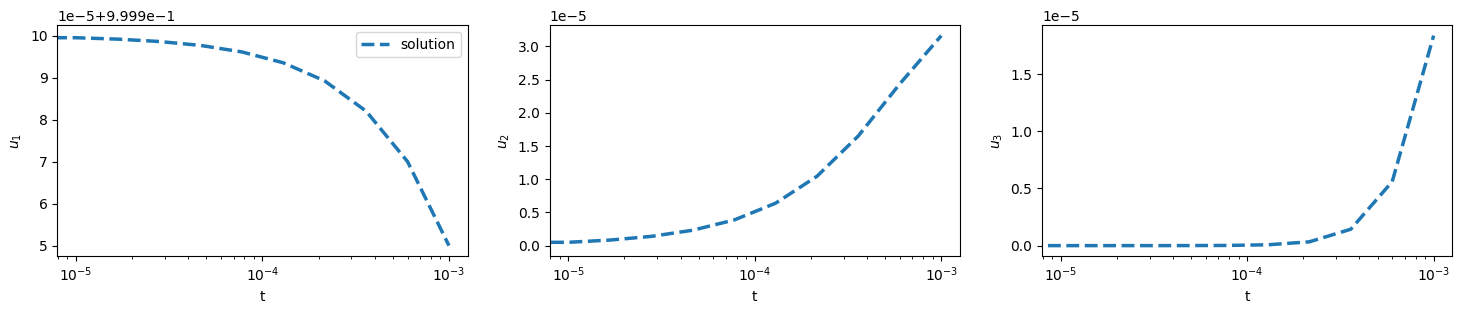

In [7]:
initial_state = torch.tensor([1.0, 0.0, 0.0], dtype=torch.float64, device=device)
func = RHSFunc().to(device)
solver = petsc_adjoint.ODEPetsc()
solver.setupTS(initial_state, func, step_size=step_size, method="cn", enable_adjoint=True, implicit_form=True)
u = solver.odeint_adjoint(initial_state, t)
visualize(t, u.detach(), "solution")
loss = torch.mean(torch.abs(u - true_u))
loss.backward()
for p in func.parameters(): print(p.grad)

## Training neural ODEs
Neural ODE is a methodology that fuses differential equations and neural networks. In this approach, the RHS $f(t,x,p)$ is approximated by a neural network whose parameters can be trained.

Assuming the RHS of the Robertson's equations is unknown, we approximate it using a NN with 5 hidden layers with 5 nodes per layer and an activation function of GELU.
<div style="font-size:22px">

```python
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 5, bias=False), nn.GELU(),
            nn.Linear(5, 5, bias=False), nn.GELU(),
            nn.Linear(5, 5, bias=False), nn.GELU(),
            nn.Linear(5, 5, bias=False), nn.GELU(),
            nn.Linear(5, 5, bias=False), nn.GELU(),
            nn.Linear(5, 5, bias=False), nn.GELU(),
            nn.Linear(5, 3, bias=False),)

    def forward(self, t, u):
        return self.net(u)
```
<div>

After setting up the neural ODE model and the optimizer, we start the optimization loop for training.    
<div style="font-size:22px">
    
```python
func_PNODE = ODEFunc().to(device)
ode_PNODE = petsc_adjoint.ODEPetsc()
ode_PNODE.setupTS(y0, func_PNODE, step_size=step_size, method="cn", enable_adjoint=True, implicit_form=True)
optimizer_PNODE = optim.AdamW(func_PNODE.parameters(), lr=5e-3)
for itr in range(curr_iter, niters + 1):
    batch_t, batch_u = get_batch()
    optimizer_PNODE.zero_grad()
    pred_u_PNODE = ode_PNODE.odeint_adjoint(u0, batch_t)
    loss_PNODE = torch.mean(torch.abs(pred_u_PNODE - batch_u))
    loss_PNODE.backward()
    optimizer_PNODE.step()
```
<div>

## Results
<table><tr>
<td>
<div style="float:left" markdown="1">
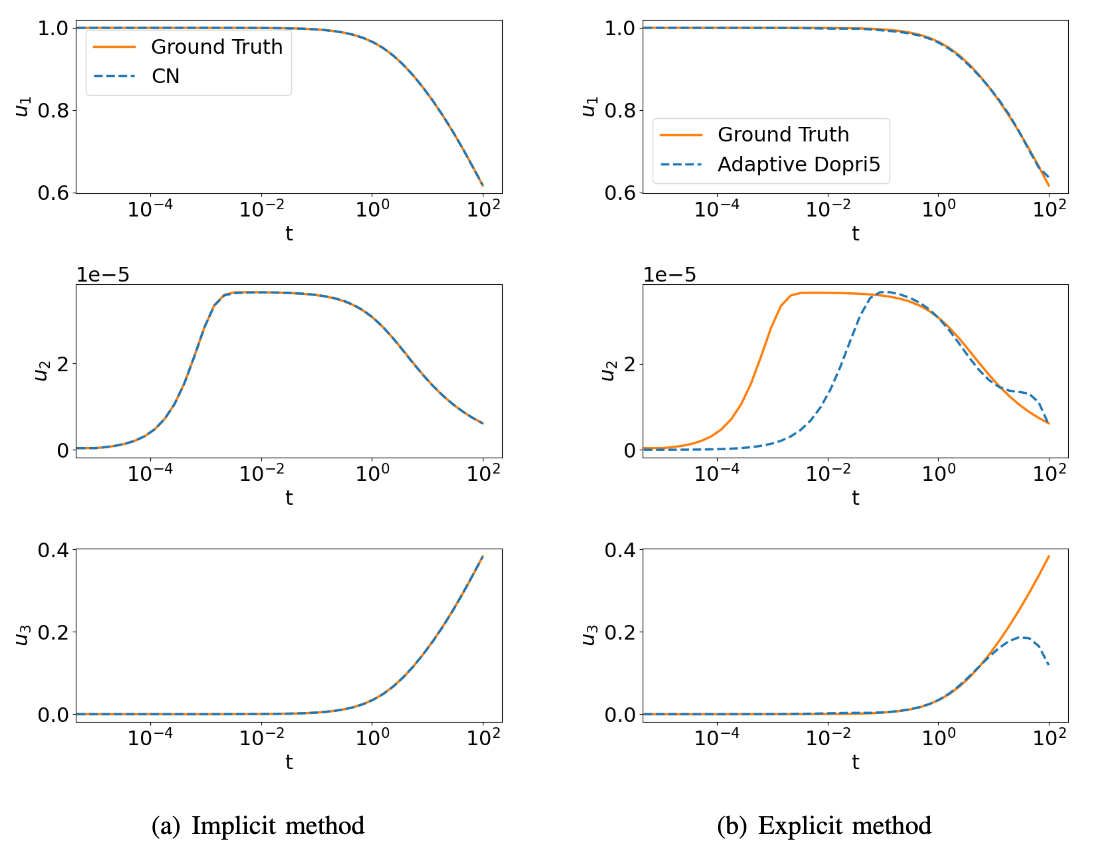
</div>
</td>
<td>

- This is a stiff dynamical sytem for which training with implicit methods work better than training with explicit methods
- Using adjoint-capable PETSc time integrators is the key to achiving performance
- One can fine-tune linear solvers, nonlinear solvers, and checkpointing for adjoint calculation with **command-line options**
- PETSc and PyTorch work together with minimal conversion overhead, full **GPU** support and **mini-batching** support
</td>
</tr></table>

## Sources for more information

- https://github.com/caidao22/pnode
- H. Zhang and W. Zhao. *A Memory-Efficient Neural Ordinary Differential Equation Framework Based on High-Level Adjoint Differentiation*. IEEE Transactions on Artificial Intelligence, pp. 1–11, 2022.
- H. Zhang, E. M. Constantinescu, and B. F. Smith. *PETSc TSAdjoint: A Discrete Adjoint ODE Solver for First-Order and Second-Order Sensitivity Analysis*. SIAM Journal on Scientific Computing. 44.1, pp. C1–C24, 2022
- H. Zhang and E. M. Constantinescu. *Optimal checkpointing for adjoint multistage time-stepping schemes*. Journal of Computational Science. 66, p. 101913, 2023.